In [1]:
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=6).start_and_connect_sync()
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


In [2]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
rank = mpi_comm.Get_rank()

In [3]:
%%capture
from pace.util import CubedSphereCommunicator, CubedSpherePartitioner, TilePartitioner

layout = (1, 1)
partitioner = CubedSpherePartitioner(TilePartitioner(layout))
communicator = CubedSphereCommunicator(mpi_comm, partitioner)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

In [4]:
from pace.util import QuantityFactory, SubtileGridSizer

backend = "numpy"

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=12,
    ny_tile=12,
    nz=79,
    n_halo=3,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

quantity_factory = QuantityFactory.from_backend(sizer=sizer, backend=backend)

In [ ]:
from datetime import datetime

restart_path = "/home/ajdas/pace/restart_data/v1.0"
restart_time = datetime.strptime("2016-08-11 00:00:00", "%Y-%m-%d %H:%M:%S")
fortran_data = True

serial_path = "/home/ajdas/pace/test_data/8.1.1/c12_6ranks_baroclinic_dycore_microphysics/driver/"
serialized_grid = True

In [ ]:
# from datetime import datetime

# restart_path = "/home/ajdas/pace/restart_data/v4.0"
# restart_time = datetime.strptime("2016-08-01 00:15:00", "%Y-%m-%d %H:%M:%S")
# fortran_data = True

# serial_path = "/home/ajdas/fv3gfs-fortran/tests/serialized_test_data_generation/data/c12_6ranks_standard_restart/dycore/"
# serialized_grid = True

In [ ]:
%%capture
from pace.driver.initialization import RestartConfig

restart_config = RestartConfig(path=restart_path, start_time=restart_time, fortran_data=fortran_data)
fortran_state = restart_config.get_driver_state(quantity_factory, communicator)

In [ ]:
import sys
sys.path.append("/usr/local/serialbox/python")
from pace.driver.initialization import SerialboxConfig

serialbox_config = SerialboxConfig(path=serial_path, serialized_grid=serialized_grid)
serialbox_state = serialbox_config.get_driver_state(quantity_factory, communicator)

In [ ]:
if mpi_rank == 0:
    print("Fortran dycore:", fortran_state.__dict__["dycore_state"].__dict__.keys())
    print("Serialbox dycore:", serialbox_state.__dict__["dycore_state"].__dict__.keys())
    print()
    print("Fortran physics:", fortran_state.__dict__["physics_state"].__dict__.keys())
    print("Serialbox physics:", serialbox_state.__dict__["physics_state"].__dict__.keys())
    print()
    print("Fortran tendency:", fortran_state.__dict__["tendency_state"].__dict__.keys())
    print("Serialbox tendency:", serialbox_state.__dict__["tendency_state"].__dict__.keys())
    print()
    print("Fortran grid data:", fortran_state.__dict__["grid_data"].__dict__.keys())
    print("Serialbox grid_data:", serialbox_state.__dict__["grid_data"].__dict__.keys())
    print()
    print("Fortran damping_coefficients:", fortran_state.__dict__["damping_coefficients"].__dict__.keys())
    print("Serialbox damping_coefficients:", serialbox_state.__dict__["damping_coefficients"].__dict__.keys())
    print()
    print("Fortran driver grid data:", fortran_state.__dict__["driver_grid_data"].__dict__.keys())
    print("Serialbox driver grid_data:", serialbox_state.__dict__["driver_grid_data"].__dict__.keys())
    print()

# Compare fortran state and serialbox state
## DYCORE

In [ ]:
import numpy as np

fortran_dycore = fortran_state.__dict__["dycore_state"]
serialbox_dycore = serialbox_state.__dict__["dycore_state"]
fortran_variable_list = sorted(list(fortran_dycore.__dict__.keys()))
serialbox_variable_list = sorted(list(serialbox_dycore.__dict__.keys()))

if mpi_rank == 0:
    print("Fortran")

fortran_vars = {}
for var in fortran_variable_list:
    try:
        fortran_vars[var] = communicator.gather(fortran_dycore.__dict__[var])
    except AttributeError:
        if mpi_rank == 0:
            print("Cannot gather: ", var)
            print("     Value: ", fortran_dycore.__dict__[var])


if mpi_rank == 0:
    print("Serialbox")
serialbox_vars = {}
for var in serialbox_variable_list:
    try:
        serialbox_vars[var] = communicator.gather(serialbox_dycore.__dict__[var])
    except AttributeError:
        if mpi_rank == 0:
            print("Cannot gather: ", var)
            print("     Value: ", serialbox_dycore.__dict__[var])


In [ ]:
from pace.util import Quantity

fortran_lon = Quantity(data=np.zeros((19, 19)), dims=("x_interface", "y_interface"), units="degrees", origin=(3, 3), extent=(13, 13), gt4py_backend=backend)
fortran_lon.data[:] = fortran_state.__dict__["grid_data"].lon * 180/np.pi
fortran_lat = Quantity(data=np.zeros((19, 19)), dims=("x_interface", "y_interface"), units="degrees", origin=(3, 3), extent=(13, 13), gt4py_backend=backend)
fortran_lat.data[:] = fortran_state.__dict__["grid_data"].lat * 180/np.pi

serialbox_lon = Quantity(data=np.zeros((19, 19)), dims=("x_interface", "y_interface"), units="degrees", origin=(3, 3), extent=(13, 13), gt4py_backend=backend)
serialbox_lon.data[:] = serialbox_state.__dict__["grid_data"].lon * 180/np.pi
serialbox_lat = Quantity(data=np.zeros((19, 19)), dims=("x_interface", "y_interface"), units="degrees", origin=(3, 3), extent=(13, 13), gt4py_backend=backend)
serialbox_lat.data[:] = serialbox_state.__dict__["grid_data"].lat * 180/np.pi



In [ ]:
flon = communicator.gather(fortran_lon)
flat = communicator.gather(fortran_lat)
slon = communicator.gather(serialbox_lon)
slat = communicator.gather(serialbox_lat)

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from fv3viz import pcolormesh_cube
from matplotlib.gridspec import GridSpec

sys.path.append("/home/ajdas/pace/examples/notebooks/")
import functions as funcs


In [ ]:
savedir = '/home/ajdas/pace/restart_data/figures_comparison_fortran_serialbox/'

for var in fortran_vars.keys():
    if var in serialbox_vars.keys():
    #if var == "qo3mr":
        #print(var)

        if mpi_rank == 0:
            fvar_index = fortran_variable_list.index(var)
            svar_index = serialbox_variable_list.index(var)

            tmp = fortran_vars[var].data
            if len(tmp.shape) == 4:
                ffield = funcs.unstagger_coordinate(fortran_vars[var].data[:, :, :, -1])
                sfield = funcs.unstagger_coordinate(serialbox_vars[var].data[:, :, :, -1])
            elif len(tmp.shape) == 3:
                ffield = funcs.unstagger_coordinate(fortran_vars[var].data[:, :, :])
                sfield = funcs.unstagger_coordinate(serialbox_vars[var].data[:, :, :])
            dfield = ffield - sfield


            minvals = min(np.nanmin(ffield), np.nanmin(sfield))
            maxvals = max(np.nanmax(ffield), np.nanmax(sfield))
            dextrema = max(np.abs(np.nanmin(dfield)), np.abs(np.nanmax(dfield)))
            if minvals == maxvals:
                minvals -= .1
                maxvals += .1
                dextrema += .1

    
            fig = plt.figure(figsize = (20, 4))
            fig.patch.set_facecolor('white')
            gs = GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,.08])
            fvar = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
            svar = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
            dvar = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson())

            cax_f = fig.add_subplot(gs[1, 0])
            cax_s = fig.add_subplot(gs[1, 1])
            cax_d = fig.add_subplot(gs[1, 2])

            f1 = pcolormesh_cube(flat.data, flon.data, ffield, ax=fvar, vmin=minvals, vmax=maxvals)
            f2 = pcolormesh_cube(flat.data, flon.data, sfield, ax=svar, vmin=minvals, vmax=maxvals)
            f3 = pcolormesh_cube(flat.data, flon.data, dfield, ax=dvar, vmin=-dextrema, vmax=dextrema, cmap="bwr")

            plt.colorbar(f1, cax=cax_f, orientation="horizontal", label=fortran_vars[var].units)
            plt.colorbar(f2, cax=cax_s, orientation="horizontal", label=fortran_vars[var].units)
            plt.colorbar(f3, cax=cax_d, orientation="horizontal", label=fortran_vars[var].units)

            fvar.set_title("%s in fortran-restart\nMin, max: (%.3e, %.3e)" % (var, ffield.min(), ffield.max()))
            svar.set_title("%s in serialbox-restart\nMin, max: (%.3e, %.3e)" % (var, sfield.min(), sfield.max()))
            dvar.set_title("fortran - serialbox % s\nMin, max: (%.3e, %.3e)" % (var, dfield.min(), dfield.max()))

            plt.savefig(savedir + "FS_dycoreState_v0_%s.png" % var, dpi=200, bbox_inches='tight')

            plt.show()

In [ ]:
from netCDF4 import Dataset

restart_path = "/home/ajdas/pace/restart_data/v1.0"
serial_path = "/home/ajdas/pace/test_data/8.1.1/c12_6ranks_baroclinic_dycore_microphysics/driver/"

ser_data = Dataset(serial_path + "Driver-In.nc", 'r')
pt_s = np.array(ser_data["pt"][0])
ser_data.close()

pt_f = []
for tile in range(1, 7, 1):
    for_data = Dataset(restart_path + "/fv_core.res.tile%s.nc" %tile, "r")
    pt_f.append(np.array(for_data["T"][0]))
    for_data.close()

pt_f = np.stack(pt_f)

# if mpi_rank == 0:
#     print(delp_s.shape, delp_f.shape)

In [ ]:
fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.pcolormesh(pt_s[mpi_rank, 3:-3, 3:-3, -1].T)
ax2.pcolormesh(pt_f[mpi_rank, -1])
ax3.pcolormesh(pt_f[mpi_rank, -1]-pt_s[mpi_rank, 3:-3, 3:-3, -1].T, cmap="bwr", vmin=-3, vmax=3)


In [ ]:
fortran_path = "/home/ajdas/pace/restart_data/v4.0/"
serial_path = "/home/ajdas/pace/test_data/8.1.1/c12_6ranks_standard_restart_15min/"


In [ ]:
#data = Dataset(serial_path + "GFSPhysicsDriver-In.nc", "r")


In [ ]:
#data

In [ ]:
data = Dataset(serial_path + "GFSPhysicsDriver-In.nc", "r")
delp_s = np.array(data["delp"][0])
pt_s = np.array(data["pt"][0])
data.close()
delp_s = delp_s[:, 3:-3, 3:-3]
pt_s = pt_s[:, 3:-3, 3:-3]

delp_f = []
pt_f = []
for tile in range(1, 7, 1):
    for_data = Dataset(restart_path + "/fv_core.res.tile%s.nc" %tile, "r")
    delp_f.append(np.array(for_data["delp"][0]))
    pt_f.append(np.array(for_data["T"][0]))
    for_data.close()

delp_f = np.stack(delp_f)
delp_f = np.transpose(delp_f, (0, 3, 2, 1))
pt_f = np.stack(pt_f)
pt_f = np.transpose(pt_f, (0, 3, 2, 1))

if mpi_rank == 0:
    print(delp_s.shape, delp_f.shape)

In [ ]:
if mpi_rank == 0:
    for lev in range(79):
        print("F delp min, max at lev %s: %.2f, %.2f" % (lev, np.nanmin(delp_f[:, :, :, -lev]), np.nanmax(np.nanmax(delp_f[:, :, :, -lev]))))
        print("S delp min, max at lev %s: %.2f, %.2f" % (lev, np.nanmin(delp_s[:, :, :, lev]), np.nanmax(np.nanmax(delp_s[:, :, :, lev]))))
        print("   max diff at lev %s: %.2e" % (lev, np.nanmax(np.abs(delp_f[:, :, :, -lev] - delp_s[:, :, :, lev]))))

In [ ]:
if mpi_rank == 0:
    var = "delp"
    lev = 0

    ffield = delp_f[:, :, :, -lev-1]
    sfield = delp_s[:, :, :, lev]
    dfield = ffield - sfield
    print(ffield.min(), ffield.max())

    minvals = min(np.nanmin(ffield), np.nanmin(sfield))
    maxvals = max(np.nanmax(ffield), np.nanmax(sfield))
    dextrema = max(np.abs(np.nanmin(dfield)), np.abs(np.nanmax(dfield)))
    if minvals == maxvals:
        minvals -= .1
        maxvals += .1
        dextrema += .1

    fig = plt.figure(figsize = (20, 4))
    fig.patch.set_facecolor('white')
    gs = GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,.08])
    fvar = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
    svar = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
    dvar = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson())

    cax_f = fig.add_subplot(gs[1, 0])
    cax_s = fig.add_subplot(gs[1, 1])
    cax_d = fig.add_subplot(gs[1, 2])

    f1 = pcolormesh_cube(flat.data, flon.data, ffield, ax=fvar, vmin=minvals, vmax=maxvals)
    f2 = pcolormesh_cube(flat.data, flon.data, sfield, ax=svar, vmin=minvals, vmax=maxvals)
    f3 = pcolormesh_cube(flat.data, flon.data, dfield, ax=dvar, vmin=-dextrema, vmax=dextrema, cmap="bwr")

    plt.colorbar(f1, cax=cax_f, orientation="horizontal", label=fortran_vars[var].units)
    plt.colorbar(f2, cax=cax_s, orientation="horizontal", label=fortran_vars[var].units)
    plt.colorbar(f3, cax=cax_d, orientation="horizontal", label=fortran_vars[var].units)

    fvar.set_title("%s in fortran-restart\nMin, max: (%.3e, %.3e)" % (var, ffield.min(), ffield.max()))
    svar.set_title("%s in serialbox-restart\nMin, max: (%.3e, %.3e)" % (var, sfield.min(), sfield.max()))
    dvar.set_title("lev %s fortran - serialbox % s\nMin, max: (%.3e, %.3e)" % (lev, var, dfield.min(), dfield.max()))

    #plt.savefig(savedir + "FS_dycoreState_v0_%s.png" % var, dpi=200, bbox_inches='tight')

    plt.show()

In [ ]:
if mpi_rank == 0:
    var = "pt"
    lev = 0

    ffield = pt_f[:, :, :, lev]
    sfield = pt_s[:, :, :, -lev-1]
    dfield = ffield - sfield

    minvals = min(np.nanmin(ffield), np.nanmin(sfield))
    maxvals = max(np.nanmax(ffield), np.nanmax(sfield))
    dextrema = max(np.abs(np.nanmin(dfield)), np.abs(np.nanmax(dfield)))
    if minvals == maxvals:
        minvals -= .1
        maxvals += .1
        dextrema += .1

    fig = plt.figure(figsize = (20, 4))
    fig.patch.set_facecolor('white')
    gs = GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,.08])
    fvar = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
    svar = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
    dvar = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson())

    cax_f = fig.add_subplot(gs[1, 0])
    cax_s = fig.add_subplot(gs[1, 1])
    cax_d = fig.add_subplot(gs[1, 2])

    f1 = pcolormesh_cube(flat.data, flon.data, ffield, ax=fvar, vmin=minvals, vmax=maxvals)
    f2 = pcolormesh_cube(flat.data, flon.data, sfield, ax=svar, vmin=minvals, vmax=maxvals)
    f3 = pcolormesh_cube(flat.data, flon.data, dfield, ax=dvar, vmin=-dextrema, vmax=dextrema, cmap="bwr")

    plt.colorbar(f1, cax=cax_f, orientation="horizontal", label=fortran_vars[var].units)
    plt.colorbar(f2, cax=cax_s, orientation="horizontal", label=fortran_vars[var].units)
    plt.colorbar(f3, cax=cax_d, orientation="horizontal", label=fortran_vars[var].units)

    fvar.set_title("%s in fortran-restart\nMin, max: (%.3e, %.3e)" % (var, ffield.min(), ffield.max()))
    svar.set_title("%s in serialbox-restart\nMin, max: (%.3e, %.3e)" % (var, sfield.min(), sfield.max()))
    dvar.set_title("lev %s fortran - serialbox % s\nMin, max: (%.3e, %.3e)" % (lev, var, dfield.min(), dfield.max()))

    #plt.savefig(savedir + "FS_dycoreState_v0_%s.png" % var, dpi=200, bbox_inches='tight')

    plt.show()

# DIFFERENT TEST CASE - standard

In [13]:
from datetime import datetime

restart_path = "/home/ajdas/pace/restart_data/v4.0"
restart_time = datetime.strptime("2016-08-01 00:15:00", "%Y-%m-%d %H:%M:%S")
fortran_data = True


In [14]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

In [15]:
%%capture
from pace.util import CubedSphereCommunicator, CubedSpherePartitioner, Quantity, TilePartitioner

layout = (1, 1)
partitioner = CubedSpherePartitioner(TilePartitioner(layout))
communicator = CubedSphereCommunicator(mpi_comm, partitioner)

In [16]:
from pace.util import QuantityFactory, SubtileGridSizer

backend = "numpy"

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=12,
    ny_tile=12,
    nz=79,
    n_halo=3,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

quantity_factory = QuantityFactory.from_backend(sizer=sizer, backend=backend)

In [17]:
%%capture
from pace.driver.initialization import RestartConfig

restart_config = RestartConfig(path=restart_path, start_time=restart_time, fortran_data=fortran_data)
fortran_state = restart_config.get_driver_state(quantity_factory, communicator)

In [18]:
import pace.util.grid
import numpy as np
from netCDF4 import Dataset

path = restart_path
fortran_data = True

metric_terms = pace.util.grid.MetricTerms(quantity_factory=quantity_factory, communicator=communicator)
horizontal_grid_data = pace.util.grid.HorizontalGridData.new_from_metric_terms(metric_terms)
contravariant_grid_data = pace.util.grid.ContravariantGridData.new_from_metric_terms(metric_terms)
angle_grid_data = pace.util.grid.AngleGridData.new_from_metric_terms(metric_terms)

data = Dataset(path + "/fv_core.res.nc", "r")
ak = np.array(data["ak"])
bk = np.array(data["bk"])
data.close()

ptop = 300
ks = 0

vertical_grid_data = pace.util.grid.VerticalGridData(ptop, ks, ak, bk)

grid_data = pace.util.grid.GridData(horizontal_grid_data, vertical_grid_data, contravariant_grid_data, angle_grid_data)


[stderr:5] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:2] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


In [19]:
damping_coefficients = pace.util.grid.DampingCoefficients.new_from_metric_terms(metric_terms)
driver_grid_data = pace.util.grid.DriverGridData.new_from_metric_terms(metric_terms)
dycore_state = pace.fv3core.DycoreState.init_zeros(quantity_factory=quantity_factory)
backend_uses_gpu = pace.dsl.gt4py_utils.is_gpu_backend(dycore_state.u.metadata.gt4py_backend)

dycore_state = pace.driver.state._overwrite_state_from_fortran_restart(
            path,
            communicator,
            dycore_state,
            "restart_dycore_state",
            backend_uses_gpu,
        )


[stdout:5] Rank: 5


[stdout:0] Rank: 0


[stdout:1] Rank: 1


[stdout:4] Rank: 4


[stdout:2] Rank: 2


[stdout:3] Rank: 3


In [20]:
ser_datadir = "/home/ajdas/pace/test_data/8.1.1/v4.0/"

data = Dataset(ser_datadir + "Driver-In.nc", "r")
pt = np.array(data["pt"][0, :, 3:-3, 3:-3])
delp = np.array(data["delp"][0, :, 3:-3, 3:-3])
data.close()

data = Dataset(ser_datadir + "GridGrid-Out.nc", "r")
lon = np.array(data["grid"][0, :, 3:-3, 3:-3, 0])
lat = np.array(data["grid"][0, :, 3:-3, 3:-3, 1])
data.close()


In [21]:
pt_driver = dycore_state.pt
delp_driver = dycore_state.delp

lon_driver = Quantity(
    data = grid_data.lon.data,
    dims=("x_interface", "y_interface"),
    units="rad",
    origin=(3, 3),
    extent=(13, 13),
    gt4py_backend="numpy",
)

import copy as cp
lat_driver = cp.deepcopy(lon_driver)
lat_driver.data[:] = grid_data.lat.data


pt_driver_g = communicator.gather(pt_driver)
delp_driver_g = communicator.gather(delp_driver)

lon_driver_g = communicator.gather(lon_driver)
lat_driver_g = communicator.gather(lat_driver)

In [32]:
lon_fs = cp.deepcopy(lon_driver)
lon_fs.data[:] = fortran_state.grid_data.lon.data
lat_fs = cp.deepcopy(lon_driver)
lat_fs.data[:] = fortran_state.grid_data.lat.data

pt_fs = fortran_state.dycore_state.pt
pt_fs_g = communicator.gather(pt_fs)


[output:0]

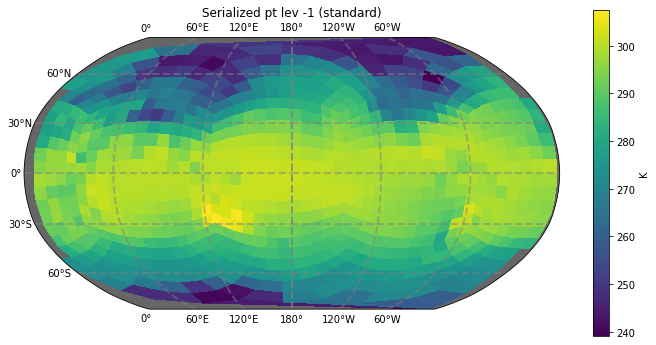

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

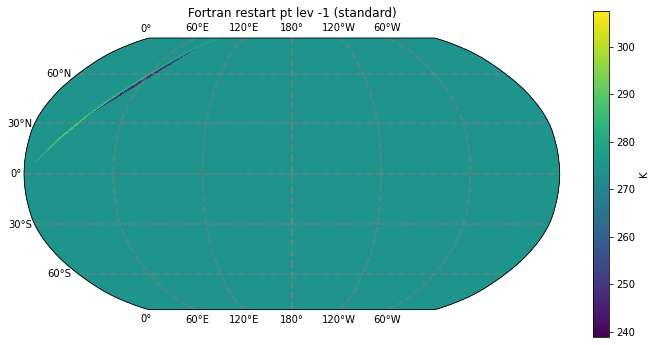

In [33]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

if rank == 0:
    lon_g = np.rad2deg(lon)
    lat_g = np.rad2deg(lat)
    lonD_g = np.rad2deg(lon_driver_g.view[:])
    latD_g = np.rad2deg(lon_driver_g.view[:])

    pt_driver_p = pt_driver_g.view[:]
    delp_driver_p = delp_driver_g.view[:]

    pt_fs_p = pt_fs_g.view[:]

    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=180))
    ax.set_facecolor(".4")
    ax.set_global()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--', xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30))

    ax.set_title("Serialized pt lev -1 (standard)")

    f1 = pcolormesh_cube(
        lat_g,
        lon_g,
        pt[:, :, :, -1],
        cmap="viridis",
    )

    plt.colorbar(f1, label="K")


    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=180))
    ax.set_facecolor(".4")
    ax.set_global()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--', xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30))

    ax.set_title("Fortran restart pt lev -1 (standard)")

    f1 = pcolormesh_cube(
        latD_g,
        lonD_g,
        pt_fs_p[:, :, :, -1],
        cmap="viridis",
    )

    plt.colorbar(f1, label="K")

    
    plt.show()


In [39]:
lonD_g.max()

Out[0:38]: 358.28298505985214

[1:execute]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Input In [38], in <cell line: 1>()
----> 1 lonD_g.max()

NameError: name 'lonD_g' is not defined
[3:execute]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Input In [38], in <cell line: 1>()
----> 1 lonD_g.max()

NameError: name 'lonD_g' is not defined
[5:execute]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Input In [38], in <cell line: 1>()
----> 1 lonD_g.max()

NameError: name 'lonD_g' is not defined
[2:execute]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Input In [38], in <cell line: 1>()
----> 1 lonD_g.max

AlreadyDisplayedError: 5 errors